## Imports & Config

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve

import joblib
import warnings
warnings.filterwarnings("ignore")

PROJECT_ROOT = Path("../")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
MODEL_DIR = PROJECT_ROOT / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)


## Load Processed Transaction Data
### We will use:
#### transactions_feature_engineered.csv
#### customer_rfm_summary.csv
#### customer_features_for_model.csv

In [38]:
transactions = pd.read_csv(DATA_PROCESSED / "transactions_feature_engineered.csv")
rfm = pd.read_csv(DATA_PROCESSED / "customer_rfm_summary.csv")
behavior = pd.read_csv(DATA_PROCESSED / "customer_features_for_model.csv")
df = rfm.merge(behavior, on="Account_Number", how="left")
df.head()

,Account_Number,last_txn_date,frequency,monetary,avg_monetary,customer_age,customer_income,account_balance,recency_days,txn_count,total_spend,avg_spend,std_spend,failed_txn_count,online_txn_count,Discount_Applied_mean,Loyalty_Points_Earned_sum,online_txn_ratio,failed_txn_ratio
0,AAGF56964741331151,2023-12-15 09:18:14,1,4132.80,4132.80,32,117819.25,15563.02,402,1,4132.80,4132.80,NaN,1,0,0.0,484,0.0,1.0
1,AAHF65030524114207,2023-03-03 22:30:11,1,2836.60,2836.60,58,109834.12,6317.92,688,1,2836.60,2836.60,NaN,0,0,1.0,486,0.0,0.0
2,AAJK21289915114551,2023-03-27 21:16:09,1,1503.49,1503.49,49,87552.61,1876.15,664,1,1503.49,1503.49,NaN,0,0,0.0,260,0.0,0.0
3,AANF38183924516791,2024-03-22 13:40:48,1,875.14,875.14,34,131361.80,13445.36,303,1,875.14,875.14,NaN,1,0,0.0,79,0.0,1.0
4,AASV46584639248878,2025-01-12 13:12:40,1,3773.31,3773.31,21,52507.80,1899.08,7,1,3773.31,3773.31,NaN,0,0,1.0,231,0.0,0.0


## Create Synthetic Loan Dataset

### Generate loan application features

In [39]:
np.random.seed(42)

loan_df = df.copy()

# Loan amounts between 50k and 25 lakh
loan_df["loan_amount"] = np.random.randint(50000, 2500000, size=len(df))

# Loan term in months
loan_df["loan_term"] = np.random.choice([12, 24, 36, 48, 60], size=len(df))

# Loan purpose (categorical)
loan_df["loan_purpose"] = np.random.choice(
    ["Home", "Personal", "Education", "Vehicle", "Business"],
    size=len(df)
)


### Create a synthetic default probability based on realistic indicators

In [40]:
# Factors increasing default risk
loan_df["risk_score"] = (
    (loan_df["loan_amount"] / (loan_df["customer_income"] + 1)) * 0.4 +
    (loan_df["recency_days"] / 90).clip(0, 1) * 0.2 +
    (loan_df["failed_txn_ratio"].fillna(0)) * 0.2 +
    (loan_df["std_spend"].fillna(0) / (loan_df["avg_spend"] + 1)).clip(0, 3) * 0.2
)

# Normalize to 0–1
loan_df["risk_score"] = (
    (loan_df["risk_score"] - loan_df["risk_score"].min()) /
    (loan_df["risk_score"].max() - loan_df["risk_score"].min())
)

# Higher risk → more chance of default
loan_df["default_flag"] = (loan_df["risk_score"] > np.random.rand(len(loan_df))).astype(int)

loan_df["default_flag"].value_counts(normalize=True)
loan_df.to_csv(DATA_PROCESSED / "loan_generated.csv", index=False)


## Model Dataset Prep

In [41]:
X = loan_df[[
    "loan_amount", "loan_term", "loan_purpose",
    "customer_age", "customer_income",
    "account_balance", "recency_days",
    "frequency", "monetary", "avg_monetary",
    "txn_count", "avg_spend", "std_spend",
    "failed_txn_ratio", "online_txn_ratio"
]]

y = loan_df["default_flag"]


## Train-test split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


## Preprocessing

In [43]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = ["loan_purpose"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


In [44]:
X_train.isna().sum().sort_values(ascending=False).head(20)


std_spend           4041
loan_amount            0
loan_term              0
loan_purpose           0
customer_age           0
customer_income        0
account_balance        0
recency_days           0
frequency              0
monetary               0
avg_monetary           0
txn_count              0
avg_spend              0
failed_txn_ratio       0
online_txn_ratio       0
dtype: int64

In [45]:
X = X.replace([np.inf, -np.inf], np.nan)
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test  = X_test.replace([np.inf, -np.inf], np.nan)

In [46]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),   # ⬅️ important
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),  # ⬅️ important
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

## Baseline Model — Logistic Regression

In [47]:
log_clf = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=500, class_weight="balanced"))
])

log_clf.fit(X_train, y_train)
y_pred_lr = log_clf.predict(X_test)
y_proba_lr = log_clf.predict_proba(X_test)[:, 1]

## Advanced Model — HistGradientBoostingClassifier

In [48]:
hgb = Pipeline([
    ("prep", preprocessor),
    ("model", HistGradientBoostingClassifier(
        max_depth=5,
        learning_rate=0.05,
        max_iter=400
    ))
])

hgb.fit(X_train, y_train)
y_proba_hgb = hgb.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba_hgb))


ROC-AUC: 0.7096406543309198


## ROC curves

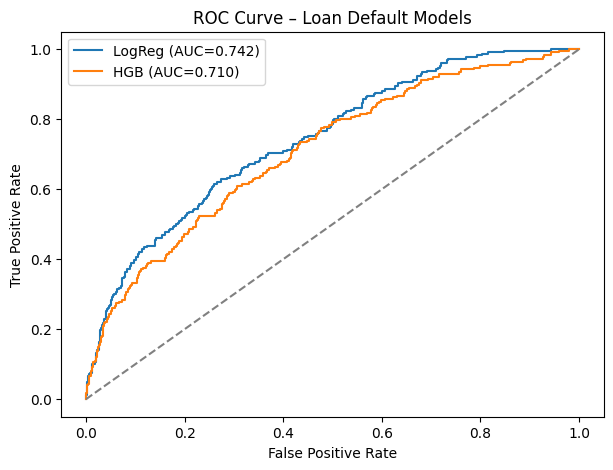

In [49]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

# ROC for both models
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_hgb, tpr_hgb, _ = roc_curve(y_test, y_proba_hgb)

auc_lr = roc_auc_score(y_test, y_proba_lr)
auc_hgb = roc_auc_score(y_test, y_proba_hgb)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={auc_lr:.3f})")
ax.plot(fpr_hgb, tpr_hgb, label=f"HGB (AUC={auc_hgb:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--", color="gray")

ax.set_title("ROC Curve – Loan Default Models")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
plt.show()


## Risk Banding

In [50]:
risk_df = X_test.copy()
risk_df["pd"] = y_proba_hgb
risk_df["actual"] = y_test.values

# Tertile segmentation
low_thr = risk_df["pd"].quantile(0.33)
high_thr = risk_df["pd"].quantile(0.66)

def risk_band(p):
    if p <= low_thr: return "Low"
    elif p <= high_thr: return "Medium"
    else: return "High"

risk_df["risk_band"] = risk_df["pd"].apply(risk_band)

risk_df.groupby("risk_band")["actual"].mean()


risk_band
High      0.288210
Low       0.069663
Medium    0.141573
Name: actual, dtype: float64

## Save Final Model

In [51]:
joblib.dump(hgb, MODEL_DIR / "loan_risk_model.joblib")


['../models/loan_risk_model.joblib']

## Visualization


### Target / Class Balance Plots

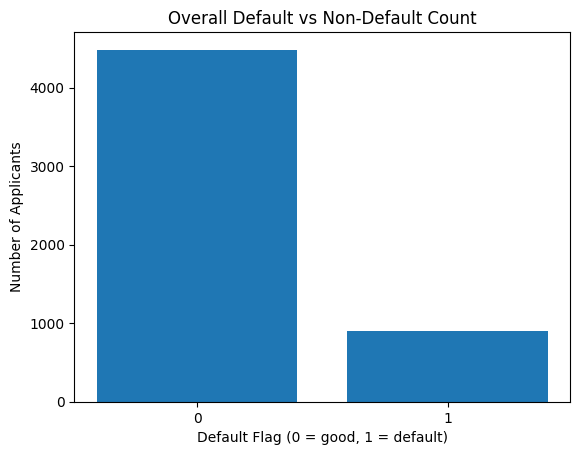

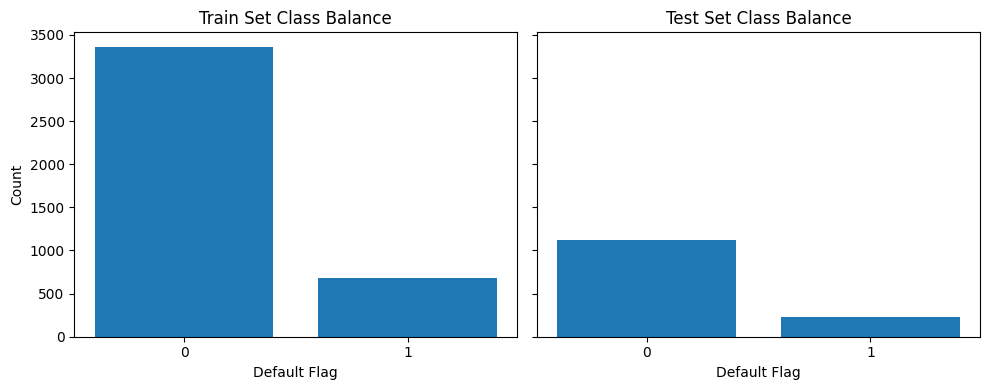

In [52]:
# Overall class balance
fig, ax = plt.subplots()
counts = y.value_counts().sort_index()
ax.bar(counts.index.astype(str), counts.values)
ax.set_title("Overall Default vs Non-Default Count")
ax.set_xlabel("Default Flag (0 = good, 1 = default)")
ax.set_ylabel("Number of Applicants")
plt.show()

# Train vs Test balance
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

axes[0].bar(train_counts.index.astype(str), train_counts.values)
axes[0].set_title("Train Set Class Balance")
axes[0].set_xlabel("Default Flag")
axes[0].set_ylabel("Count")

axes[1].bar(test_counts.index.astype(str), test_counts.values)
axes[1].set_title("Test Set Class Balance")
axes[1].set_xlabel("Default Flag")

plt.tight_layout()
plt.show()


### Relationship between loan_amount and customer_income

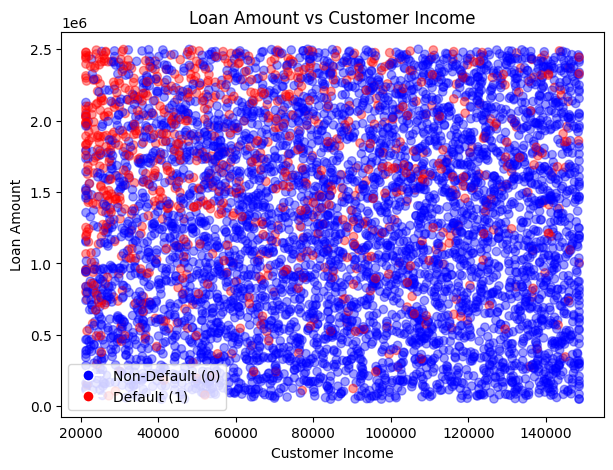

In [53]:
# Scatter plot: loan amount vs income, colored by default
fig, ax = plt.subplots(figsize=(7, 5))

colors = np.where(y == 1, "red", "blue")
ax.scatter(X["customer_income"], X["loan_amount"], c=colors, alpha=0.4)

ax.set_title("Loan Amount vs Customer Income")
ax.set_xlabel("Customer Income")
ax.set_ylabel("Loan Amount")
# Simple legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Non-Default (0)',
           markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Default (1)',
           markerfacecolor='red', markersize=8),
]
ax.legend(handles=legend_elements)
plt.show()


### PD Score & Risk Band Visualizations
#### 1. Histogram of PD scores
#### 2. PD distribution by risk band
#### 3. Default rate by risk band (bar chart)


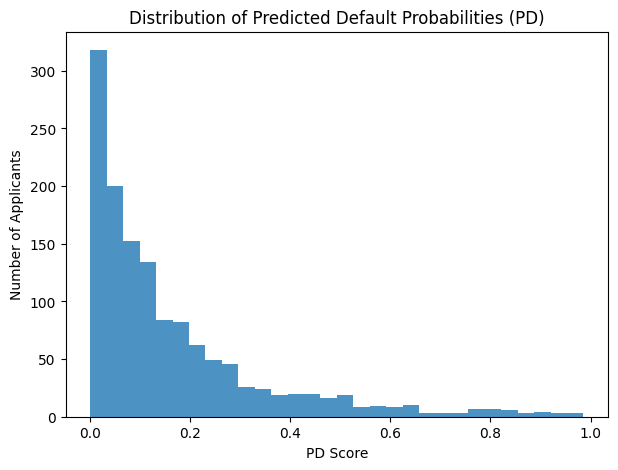

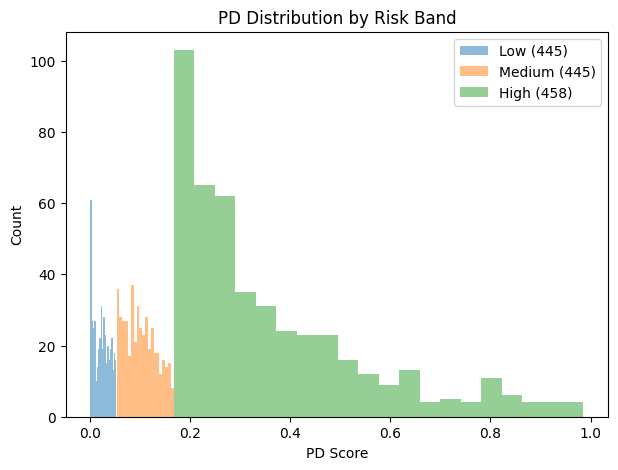

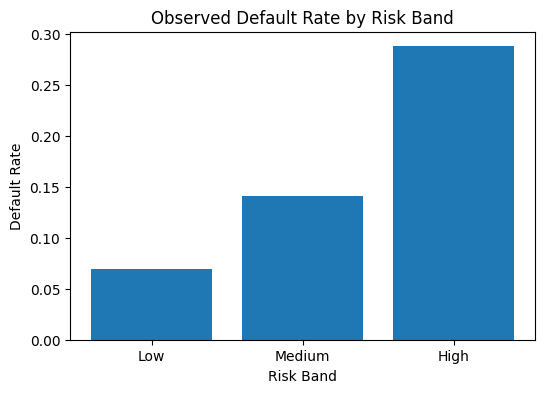

,risk_band,applicants,defaults,default_rate
1,Low,445,31,0.069663
2,Medium,445,63,0.141573
0,High,458,132,0.288210


In [54]:
risk_df = X_test.copy()
risk_df["pd"] = y_proba_hgb
risk_df["actual"] = y_test.values

low_thr = risk_df["pd"].quantile(0.33)
high_thr = risk_df["pd"].quantile(0.66)

def risk_band(p):
    if p <= low_thr:
        return "Low"
    elif p <= high_thr:
        return "Medium"
    else:
        return "High"

risk_df["risk_band"] = risk_df["pd"].apply(risk_band)
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(risk_df["pd"], bins=30, alpha=0.8)
ax.set_title("Distribution of Predicted Default Probabilities (PD)")
ax.set_xlabel("PD Score")
ax.set_ylabel("Number of Applicants")
plt.show()
fig, ax = plt.subplots(figsize=(7, 5))

bands = ["Low", "Medium", "High"]
for band in bands:
    subset = risk_df[risk_df["risk_band"] == band]["pd"]
    ax.hist(subset, bins=20, alpha=0.5, label=f"{band} ({len(subset)})")

ax.set_title("PD Distribution by Risk Band")
ax.set_xlabel("PD Score")
ax.set_ylabel("Count")
ax.legend()
plt.show()
band_summary = (
    risk_df
    .groupby("risk_band")["actual"]
    .agg(applicants="count", defaults="sum", default_rate="mean")
    .reset_index()
    .sort_values("default_rate")
)

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(band_summary["risk_band"], band_summary["default_rate"])
ax.set_title("Observed Default Rate by Risk Band")
ax.set_xlabel("Risk Band")
ax.set_ylabel("Default Rate")
plt.show()

band_summary

